# Research work: Estimating PageRank with inductive capability of Graph Neural Networks and zone partitioning

## Experiment 1: Planetoid.Cora Dataset

Three neural networks were created for computing
zone partitions metrics

In [1]:
from models import GCN, GraphSage, ChebConv
import numpy as np
import matplotlib.pyplot as plt
from graph_utils import PartitionFactory
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.datasets import FacebookPagePage, GitHub, CitationFull
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import classification_report 
from graph_utils import plot_losses

In [2]:
''' Dataset selection '''
dataset = CitationFull(root='data/CiteSeer', name = "CiteSeer", transform=NormalizeFeatures())
data = dataset[0]

In [3]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5])

## Graph Partitioning stage: 
This stage separates graph onto 5 different zones

In [4]:
from graph_utils import coo_to_edge_list
from graph_utils import edge_list_to_adj_list
from collections import deque 
def graph_preprocess(data):
    graph = coo_to_edge_list(data)
    graph = edge_list_to_adj_list(graph)
    return graph

def flooding(graph, seed, step=10):
    '''Utilite function, returns the second seed for the second
    graph by traversing from the first graph's seed N number of steps
    uses BFS strategy
    '''
    queue = deque([seed])  # for BFS
    layer = {seed: 0}  # tracks visited nodes and depth
    while queue:
        node = queue.popleft()
        for neighbour in graph[node]:
            if neighbour not in layer:
                queue.append(neighbour)  # for the next iteration
                layer[neighbour] = layer[node] + 1
            if layer[node] > step:
                break
                
    return layer


In [5]:
def bool_mask(zone, data):
    '''converts train-test to bitsets for GNN'''
    res = [False] * data.num_nodes
    for item in zone:
        res[item] = True
    return res

def make_partitions(layer_dict, step):
    '''from 0 to step: core zone
       from step to rest: undiscovered
       use after flooding!!!
    '''
    core_zone, undiscovered_zone = [], []
    for key, value in layer_dict.items():
        if value < step:
            core_zone.append(key)
        else:
            undiscovered_zone.append(key)
    return core_zone, undiscovered_zone

In [6]:
g = graph_preprocess(data.edge_index)
zone1 = flooding(g, 23, 10)
zone2 = flooding(g, 893, 10)

core_zone1, undiscovered_zone1 = make_partitions(zone1, 6)
core_zone2, undiscovered_zone2 = make_partitions(zone2, 5)
intersection_zone = set(undiscovered_zone1).intersection(undiscovered_zone2)
print(len(core_zone1))
print(len(undiscovered_zone1))
print(len(core_zone2))
print(len(undiscovered_zone2))
print(len(intersection_zone))


633
852
68
618
420


In [7]:
''' Preparing partitions for Neural network '''
train_mask_1 = torch.tensor(bool_mask(core_zone1, data))  # core zone, 1st graph
test_mask_1 = torch.tensor(bool_mask(undiscovered_zone1, data))  # undiscovered zone, 1st graph
train_mask_2 = torch.tensor(bool_mask(core_zone2, data))  # core zone, 2nd graph
test_mask_2 = torch.tensor(bool_mask(undiscovered_zone2, data))  # undiscovered zone, 2nd graph
intersection_mask = torch.tensor(bool_mask(intersection_zone, data))  # intersection zone

#### Graph Partitioning labels ###
- Core Zone 1: GREEN
- Undiscovered zone 1: YELLOW
- Core Zone 2: BLUE
- Undiscovered zone 2: ORANGE
- Intersection zone: RED
- Other nodes: GREY

### Train Test and Intersection Test utils

In [8]:
def train(nn_model, data, optimizer, criterion, train_mask):
    nn_model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = nn_model(data.x, data.edge_index)  # Perform a single forward pass.
    # Compute the loss solely based on the training nodes.
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test(nn_model, data, test_mask, target_names):
    nn_model.eval()
    out = nn_model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    # Check against ground-truth labels.
    test_correct = pred[test_mask] == data.y[test_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / test_mask.sum()
    report = classification_report(pred[intersection_mask],
        data.y[intersection_mask],
        target_names=target_names,
        zero_division=1)
    return test_acc, report

def test_intersection(nn_model1, nn_model2, data, intersection_mask, target_names):
    "The Intersection zone: tested by both neural networks"
    nn_model1.eval()
    nn_model2.eval()

    out1 = nn_model1(data.x, data.edge_index)
    out2 = nn_model2(data.x, data.edge_index)

    # get the data from the both predictions
    pred = ((out1 + out2)/2).argmax(dim=1)

    # Check against ground-truth labels.
    test_correct = pred[intersection_mask] == data.y[intersection_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / intersection_mask.sum()

    report = classification_report(pred[intersection_mask],
        data.y[intersection_mask],
        target_names=target_names,
        zero_division=1)
    return test_acc, report

## Model1: GraphConv

In [9]:
model1 = GCN(dataset, hidden_channels=16)
model2 = GCN(dataset, hidden_channels=16)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.CrossEntropyLoss()

In [10]:
loss_list1 = []
loss_list2 = []

for epoch in range(1, 500):
    loss1 = train(model1, data, optimizer1, criterion1, train_mask_1)
    loss2 = train(model2, data, optimizer2, criterion2, train_mask_2)
    loss_list1.append(loss1.item())
    loss_list2.append(loss2.item())
    print(f'Epoch: {epoch:03d}')
    print(f'NN1:{loss1:.4f}, NN2: {loss2:.4f}')

Epoch: 001
NN1:1.7915, NN2: 1.7920
Epoch: 002
NN1:1.7585, NN2: 1.7521
Epoch: 003
NN1:1.7197, NN2: 1.7113
Epoch: 004
NN1:1.6783, NN2: 1.6650
Epoch: 005
NN1:1.6258, NN2: 1.6005
Epoch: 006
NN1:1.5808, NN2: 1.5692
Epoch: 007
NN1:1.5320, NN2: 1.5136
Epoch: 008
NN1:1.4760, NN2: 1.4266
Epoch: 009
NN1:1.4141, NN2: 1.3687
Epoch: 010
NN1:1.3645, NN2: 1.3212
Epoch: 011
NN1:1.3124, NN2: 1.2659
Epoch: 012
NN1:1.2698, NN2: 1.1655
Epoch: 013
NN1:1.2160, NN2: 1.1024
Epoch: 014
NN1:1.1490, NN2: 1.0801
Epoch: 015
NN1:1.1090, NN2: 0.9956
Epoch: 016
NN1:1.0677, NN2: 0.9467
Epoch: 017
NN1:1.0311, NN2: 0.8872
Epoch: 018
NN1:0.9779, NN2: 0.8149
Epoch: 019
NN1:0.9594, NN2: 0.7088
Epoch: 020
NN1:0.8960, NN2: 0.6986
Epoch: 021
NN1:0.8745, NN2: 0.6952
Epoch: 022
NN1:0.8466, NN2: 0.5465
Epoch: 023
NN1:0.8349, NN2: 0.4937
Epoch: 024
NN1:0.8016, NN2: 0.5263
Epoch: 025
NN1:0.7616, NN2: 0.4722
Epoch: 026
NN1:0.7673, NN2: 0.4098
Epoch: 027
NN1:0.7327, NN2: 0.3638
Epoch: 028
NN1:0.7006, NN2: 0.3690
Epoch: 029
NN1:0.710

Epoch: 244
NN1:0.1753, NN2: 0.0132
Epoch: 245
NN1:0.1648, NN2: 0.0272
Epoch: 246
NN1:0.1641, NN2: 0.0424
Epoch: 247
NN1:0.1701, NN2: 0.0218
Epoch: 248
NN1:0.1678, NN2: 0.0154
Epoch: 249
NN1:0.1685, NN2: 0.0157
Epoch: 250
NN1:0.1819, NN2: 0.0095
Epoch: 251
NN1:0.1639, NN2: 0.0316
Epoch: 252
NN1:0.1833, NN2: 0.0296
Epoch: 253
NN1:0.1579, NN2: 0.0386
Epoch: 254
NN1:0.1829, NN2: 0.0216
Epoch: 255
NN1:0.1709, NN2: 0.0152
Epoch: 256
NN1:0.1672, NN2: 0.0101
Epoch: 257
NN1:0.1670, NN2: 0.0282
Epoch: 258
NN1:0.1594, NN2: 0.0271
Epoch: 259
NN1:0.1470, NN2: 0.0247
Epoch: 260
NN1:0.1665, NN2: 0.0210
Epoch: 261
NN1:0.1481, NN2: 0.0184
Epoch: 262
NN1:0.1686, NN2: 0.0227
Epoch: 263
NN1:0.1414, NN2: 0.0177
Epoch: 264
NN1:0.1699, NN2: 0.0188
Epoch: 265
NN1:0.1703, NN2: 0.0170
Epoch: 266
NN1:0.1598, NN2: 0.0280
Epoch: 267
NN1:0.1574, NN2: 0.0082
Epoch: 268
NN1:0.1867, NN2: 0.0190
Epoch: 269
NN1:0.1719, NN2: 0.0157
Epoch: 270
NN1:0.1480, NN2: 0.0181
Epoch: 271
NN1:0.1437, NN2: 0.0167
Epoch: 272
NN1:0.157

Epoch: 490
NN1:0.1206, NN2: 0.0092
Epoch: 491
NN1:0.1394, NN2: 0.0284
Epoch: 492
NN1:0.1145, NN2: 0.0217
Epoch: 493
NN1:0.1379, NN2: 0.0274
Epoch: 494
NN1:0.1226, NN2: 0.0108
Epoch: 495
NN1:0.1327, NN2: 0.0171
Epoch: 496
NN1:0.1258, NN2: 0.0092
Epoch: 497
NN1:0.1359, NN2: 0.0069
Epoch: 498
NN1:0.1382, NN2: 0.0102
Epoch: 499
NN1:0.1299, NN2: 0.0241


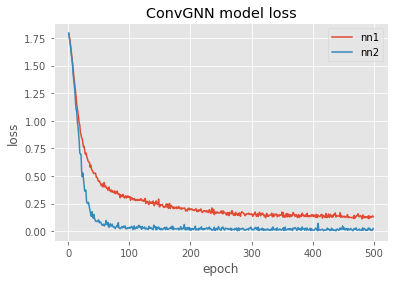

In [13]:
plot_losses(loss_list1, loss_list2, "ConvGNN")

In [15]:
target_names=['c1','c2', 'c3','c4','c5']
test_acc_1, report_1 = test(model1, data, test_mask_1, target_names)
test_acc_2, report_2 = test(model2, data, test_mask_2, target_names)
test_acc_intersection, report_intersection = test_intersection(
    model1, model2, data, intersection_mask, target_names)

print(f"NN1 Acc:{test_acc_1:.5}, NN2 Acc: {test_acc_2:.5}, Intersection Acc: {test_acc_intersection:.5}")
print('----------------------------------------------------------------------------------')
print('NN1 REPORT')
print(report_1)
print('NN2 REPORT')
print(report_2)
print('NN3 REPORT')
print(report_intersection)

NN1 Acc:0.79812, NN2 Acc: 0.85599, Intersection Acc: 0.85
----------------------------------------------------------------------------------
NN1 REPORT
              precision    recall  f1-score   support

          c1       1.00      1.00      1.00         2
          c2       0.48      0.88      0.62        17
          c3       1.00      0.44      0.62         9
          c4       0.99      0.91      0.95       392
          c5       0.00      1.00      0.00         0

    accuracy                           0.90       420
   macro avg       0.70      0.85      0.64       420
weighted avg       0.97      0.90      0.93       420

NN2 REPORT
              precision    recall  f1-score   support

          c1       0.00      1.00      0.00         0
          c2       0.00      1.00      0.00         0
          c3       0.00      1.00      0.00         0
          c4       1.00      0.85      0.92       420
          c5       0.00      1.00      0.00         0

    accuracy          

## Model 2: GraphSage

In [16]:
model1 = GraphSage(dataset, hidden_channels=16)
model2 = GraphSage(dataset, hidden_channels=16)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion1 = torch.nn.CrossEntropyLoss()
criterion2 = torch.nn.CrossEntropyLoss()

In [17]:
loss_list1 = []
loss_list2 = []

for epoch in range(1, 500):
    loss1 = train(model1, data, optimizer1, criterion1, train_mask_1)
    loss2 = train(model2, data, optimizer2, criterion2, train_mask_2)
    loss_list1.append(loss1.item())
    loss_list2.append(loss2.item())
    print(f'Epoch: {epoch:03d}')
    print(f'NN1:{loss1:.4f}, NN2: {loss2:.4f}')

Epoch: 001
NN1:1.9407, NN2: 1.9329
Epoch: 002
NN1:1.8922, NN2: 1.8762
Epoch: 003
NN1:1.8537, NN2: 1.8262
Epoch: 004
NN1:1.8011, NN2: 1.7772
Epoch: 005
NN1:1.7425, NN2: 1.7212
Epoch: 006
NN1:1.6851, NN2: 1.6090
Epoch: 007
NN1:1.6017, NN2: 1.5371
Epoch: 008
NN1:1.4983, NN2: 1.4461
Epoch: 009
NN1:1.4235, NN2: 1.3584
Epoch: 010
NN1:1.3424, NN2: 1.2608
Epoch: 011
NN1:1.2350, NN2: 1.1458
Epoch: 012
NN1:1.1492, NN2: 1.1427
Epoch: 013
NN1:1.0346, NN2: 0.9144
Epoch: 014
NN1:0.9797, NN2: 0.8926
Epoch: 015
NN1:0.9165, NN2: 0.7424
Epoch: 016
NN1:0.8297, NN2: 0.6757
Epoch: 017
NN1:0.7818, NN2: 0.6139
Epoch: 018
NN1:0.7276, NN2: 0.4937
Epoch: 019
NN1:0.6946, NN2: 0.4563
Epoch: 020
NN1:0.6341, NN2: 0.4544
Epoch: 021
NN1:0.6069, NN2: 0.2805
Epoch: 022
NN1:0.6011, NN2: 0.3167
Epoch: 023
NN1:0.5851, NN2: 0.2459
Epoch: 024
NN1:0.5495, NN2: 0.2312
Epoch: 025
NN1:0.5108, NN2: 0.1736
Epoch: 026
NN1:0.4941, NN2: 0.1855
Epoch: 027
NN1:0.4752, NN2: 0.1754
Epoch: 028
NN1:0.4809, NN2: 0.1453
Epoch: 029
NN1:0.464

Epoch: 236
NN1:0.0708, NN2: 0.0037
Epoch: 237
NN1:0.0665, NN2: 0.0060
Epoch: 238
NN1:0.0636, NN2: 0.0112
Epoch: 239
NN1:0.0669, NN2: 0.0099
Epoch: 240
NN1:0.0665, NN2: 0.0080
Epoch: 241
NN1:0.0661, NN2: 0.0047
Epoch: 242
NN1:0.0799, NN2: 0.0190
Epoch: 243
NN1:0.0666, NN2: 0.0060
Epoch: 244
NN1:0.0763, NN2: 0.0062
Epoch: 245
NN1:0.0589, NN2: 0.0018
Epoch: 246
NN1:0.0524, NN2: 0.0088
Epoch: 247
NN1:0.0736, NN2: 0.0129
Epoch: 248
NN1:0.0499, NN2: 0.0197
Epoch: 249
NN1:0.0673, NN2: 0.0052
Epoch: 250
NN1:0.0645, NN2: 0.0336
Epoch: 251
NN1:0.0729, NN2: 0.0042
Epoch: 252
NN1:0.0640, NN2: 0.0074
Epoch: 253
NN1:0.0925, NN2: 0.0043
Epoch: 254
NN1:0.0699, NN2: 0.0058
Epoch: 255
NN1:0.0746, NN2: 0.0053
Epoch: 256
NN1:0.0733, NN2: 0.0054
Epoch: 257
NN1:0.0669, NN2: 0.0078
Epoch: 258
NN1:0.0664, NN2: 0.0092
Epoch: 259
NN1:0.0550, NN2: 0.0024
Epoch: 260
NN1:0.0683, NN2: 0.0040
Epoch: 261
NN1:0.0696, NN2: 0.0033
Epoch: 262
NN1:0.0773, NN2: 0.0036
Epoch: 263
NN1:0.0682, NN2: 0.0041
Epoch: 264
NN1:0.074

Epoch: 471
NN1:0.0512, NN2: 0.0033
Epoch: 472
NN1:0.0576, NN2: 0.0044
Epoch: 473
NN1:0.0485, NN2: 0.0013
Epoch: 474
NN1:0.0493, NN2: 0.0057
Epoch: 475
NN1:0.0502, NN2: 0.0073
Epoch: 476
NN1:0.0671, NN2: 0.0064
Epoch: 477
NN1:0.0652, NN2: 0.0070
Epoch: 478
NN1:0.0576, NN2: 0.0071
Epoch: 479
NN1:0.0480, NN2: 0.0037
Epoch: 480
NN1:0.0527, NN2: 0.0027
Epoch: 481
NN1:0.0655, NN2: 0.0026
Epoch: 482
NN1:0.0510, NN2: 0.0022
Epoch: 483
NN1:0.0595, NN2: 0.0014
Epoch: 484
NN1:0.0518, NN2: 0.0037
Epoch: 485
NN1:0.0474, NN2: 0.0025
Epoch: 486
NN1:0.0560, NN2: 0.0051
Epoch: 487
NN1:0.0474, NN2: 0.0015
Epoch: 488
NN1:0.0637, NN2: 0.0090
Epoch: 489
NN1:0.0571, NN2: 0.0117
Epoch: 490
NN1:0.0494, NN2: 0.0023
Epoch: 491
NN1:0.0558, NN2: 0.0013
Epoch: 492
NN1:0.0688, NN2: 0.0021
Epoch: 493
NN1:0.0568, NN2: 0.0193
Epoch: 494
NN1:0.0624, NN2: 0.0056
Epoch: 495
NN1:0.0588, NN2: 0.0049
Epoch: 496
NN1:0.0564, NN2: 0.0041
Epoch: 497
NN1:0.0576, NN2: 0.0024
Epoch: 498
NN1:0.0673, NN2: 0.0022
Epoch: 499
NN1:0.052

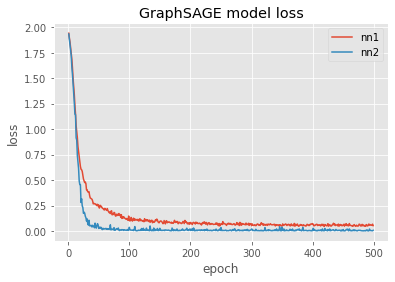

In [18]:
plot_losses(loss_list1, loss_list2, 'GraphSAGE')

In [20]:
target_names=['c1','c2', 'c3','c4','c5']
test_acc_1, report_1 = test(model1, data, test_mask_1, target_names)
test_acc_2, report_2 = test(model2, data, test_mask_2, target_names)
test_acc_intersection, report_intersection = test_intersection(
    model1, model2, data, intersection_mask, target_names)

print(f"NN1 Acc:{test_acc_1:.5}, NN2 Acc: {test_acc_2:.5}, Intersection Acc: {test_acc_intersection:.5}")
print('----------------------------------------------------------------------------------')
print('NN1 REPORT')
print(report_1)
print('NN2 REPORT')
print(report_2)
print('NN3 REPORT')
print(report_intersection)

NN1 Acc:0.79812, NN2 Acc: 0.85599, Intersection Acc: 0.85
----------------------------------------------------------------------------------
NN1 REPORT
              precision    recall  f1-score   support

          c1       1.00      1.00      1.00         2
          c2       0.65      0.77      0.70        26
          c3       1.00      0.80      0.89         5
          c4       0.99      0.91      0.95       387
          c5       0.00      1.00      0.00         0

    accuracy                           0.90       420
   macro avg       0.73      0.90      0.71       420
weighted avg       0.97      0.90      0.93       420

NN2 REPORT
              precision    recall  f1-score   support

          c1       0.00      1.00      0.00         0
          c2       0.00      1.00      0.00         0
          c3       0.00      1.00      0.00         0
          c4       1.00      0.85      0.92       420
          c5       0.00      1.00      0.00         0

    accuracy          